## DEPENDENCE INSTALL

- Dependencies install for evaluation of metrics
- Instalação das depedendencias necessárias para executar todos as avaliações

In [76]:
%pip install numpy cython
%pip install wheel
%pip install ir_datasets
%pip install scikit-learn
%pip install nltk
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import ir_datasets
import numpy as np
import requests
import json
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score


In [4]:
dataset = ir_datasets.load('cranfield')

In [5]:
dataset.docs_count()

1400

## EVALUETION FUNCTIONS

- Implementação de funções em algoritimos para executar as avaliações


### Calculo do DCG@k

In [6]:
def calc_dcg_k(relevance):
  result = 0
  for i in range(len(relevance)):
    log = np.log2(1 + (i + 1))
    result += (relevance[i] / log)
  return result

### Calculo NDCG@K

In [7]:
def calc_ndcg_k(relevance, true_relevance):
  return calc_dcg_k(relevance) / calc_dcg_k(true_relevance)

#### Exemplos

In [51]:
relevance = [0, 3, 3]
true_relevance = [4,3,3]

In [52]:
calc_ndcg_k(relevance, true_relevance)

0.45893222991541405

In [10]:
ndcg_score(np.asarray([true_relevance]), np.asarray([relevance]))

0.9999999999999999

## INDEXAR DOCUMENTOS

In [11]:
url = 'http://127.0.0.1:8080/nir'

In [12]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thiagoluizrodrigues/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
count = 0
for doc in dataset.docs_iter():

  sents = list(word_tokenize(doc.text))
  # temps = []
  # for sent in sent:
  #   temps.append(re.sub('[^A-Za-z\-]', '', sent))

  mystr = ' '.join(map(str, sents))


  myobj = {
            'id': doc.doc_id,
            'title': doc.title.strip(),
            'body': mystr.strip()
          }

  response = 201 #/requests.post(url, json = myobj)
  if response.status_code == 201:
    count += 1
  else:
    print("DOC ID ", doc.doc_id, "Status ", response.status_code)
    print(response.text)

print("Indexed ", count)

AttributeError: 'int' object has no attribute 'status_code'

In [14]:
dataset.docs_cls()

ir_datasets.datasets.cranfield.CranfieldDoc

### Calculo do DCG@k

## EFETUAR BUSCAS

In [15]:
documents = []

In [16]:
url = "http://127.0.0.1:8080/nir?query="

In [17]:
count = 0
for query in dataset.queries_iter():

  # sent = list(word_tokenize(query.text))
  # mystr = ' '.join(map(str, sent))
  qry = url + query.text + "&semantic=0"
  x = requests.get(qry)

  if x.status_code == 200:
    obj = json.loads(x.text)
    documents.append({
        "query_id":query.query_id,
        "result":obj
    })
    count += 1


print("Total..: ",count)
  # print("Query ID:", query.query_id, "Status code:", x.status_code)

Total..:  225


In [18]:
#import pandas as pd
#pd.DataFrame(dataset.queries_iter())

In [19]:
def get_documents(query_id):
    temp_documents = []
    for doc in documents:
        if str(query_id) != doc['query_id']:
            continue
        query_results = doc['result']['queryResults']
        for result in query_results:
            temp_documents.append(result)
    return temp_documents


In [20]:
def get_qrels(query_id):
    temp_qrels = []
    for qrel in dataset.qrels_iter():
        if qrel.query_id == str(query_id): 
            temp_qrels.append(qrel)

    return temp_qrels
    

In [21]:
def get_doc_relevance(doc_id, qrels):
    for qrel in qrels:
        if (qrel.doc_id == str(doc_id)):
            return qrel.relevance
    return 0

In [22]:
class DocResult:
    def __init__(self, query_id, document_id, relevance, seq):
        self.query_id = query_id
        self.document_id = document_id
        self.relevance = relevance
        self.seq = seq


In [23]:
def get_query_result_docs(query_id, query_documents):
  
  temp_docs = []
  qrels = get_qrels(query_id)

  seq = 0
  for doc in query_documents:
    document_id = doc['document']['id']
    relevance = get_doc_relevance(document_id, qrels)
    seq += 1
    temp_docs.append(DocResult(query_id, document_id, relevance, seq))
  
  return temp_docs

  


In [24]:
def get_query_relevance(query_id):
    result_docs = get_query_result_docs(query_id=query_id, query_documents=get_documents(query_id=query_id))

    relevance = []
    for x in result_docs:
        relevance.append(x.relevance)
        #print("K:", i, " ",x.document_id, " ", x.relevance)
    return relevance

In [25]:
def get_true_relevance(query_id):
    true_relevance = []
    for qrel in get_qrels(query_id=query_id)[0:10]:
        true_relevance.append(qrel.relevance)
    return true_relevance

In [26]:
relevance = get_query_relevance(query_id=1)
true_relevance = get_true_relevance(query_id=1)
calc_ndcg_k(relevance,true_relevance)

0.40187973127517235

In [32]:
def sum_relevance(relevances):
    sm = 0
    for x in relevances:
        sm += x
    return sm

In [61]:
import pandas as pd

query_id = []
true_dcg_k = []
nir_dcg_k = []
nir_ndcg_k = []

for id in range(1,256):
    true_relevance = get_true_relevance(query_id=id)
    relevance = get_query_relevance(query_id=id)

    if sum_relevance(relevance) > 0:
        query_id.append(id)
        true_dcg_k.append(calc_dcg_k(true_relevance))
        nir_dcg_k.append(calc_dcg_k(relevance))
        nir_ndcg_k.append(calc_ndcg_k(relevance,true_relevance))
            
            
details = {
    'query_id': query_id,
    'true_dcg_k': true_dcg_k,
    'nir_dcg_k': nir_dcg_k,
    'nir_ndcg_k': nir_ndcg_k,
}


df = pd.DataFrame(details)
df.to_csv('nir_ndcg.csv')
df

,query_id,true_dcg_k,nir_dcg_k,nir_ndcg_k
0,1,12.160512,4.887063,0.401880
1,2,10.974631,5.669101,0.516564
2,56,15.043308,1.160558,0.077148
3,83,4.736360,0.712414,0.150414
4,97,14.749237,1.156259,0.078395
5,100,10.010156,0.666667,0.066599
6,171,3.200253,0.386853,0.120882
7,189,10.676822,0.666667,0.062441
8,196,11.216587,1.068622,0.095272
9,212,12.449576,3.075449,0.247032


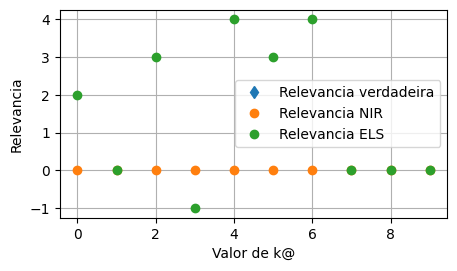

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2, 100)  # Sample data.

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7))
# ax.scatter(relevance, true_relevance, s=50, facecolor='C0', edgecolor='k')
ax.plot(true_relevance, 'd', label='Relevancia verdadeira')
ax.plot(relevance, 'o', label='Relevancia NIR')
ax.plot([2, 0, 3, -1, 4, 3, 4, 0, 0, 0], 'o', label='Relevancia ELS')
ax.set_xlabel('Valor de k@')
ax.set_ylabel('Relevancia')
ax.legend()
ax.grid(True)
